# Exploratory data analysis

Running **calculate_kld.py** on the doctopics file produced by topic modeling gives us a bunch of "summary" files. We need to join them and see what we've got.

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import glob, math
from scipy.stats import pearsonr, zscore, ttest_ind

### Load metadata for future reference

We'll need it.

In [10]:
meta = pd.read_csv('../meta/filteredsample.tsv', sep = '\t', index_col = 'docid')

### Examining the KLD curve across time

We calculated KLD for three different "fractions" of the dataset.

1. Using all the volumes is "fraction 1.0." We calculate KLD(this volume|vol in future or part) for every volume at a given temporal offset, and report the mean here.

2. But because we expect literary influence not to be diffused universally, we also calculate KLD for *the closest 5%* of volumes in a given year. This is fraction 0.05.

3. And because it's possible that differentiation is very strong, also fraction 0.025.

Let's read in one of the kld files, produced around the middle of the timeline.

In [4]:
kl = pd.read_csv('../results/seg15000klds.tsv', sep = '\t')
kl.head()

,docid,fraction,-50,-49,-48,-47,-46,-45,-44,-43,...,41,42,43,44,45,46,47,48,49,50
0,uc2.ark+=13960=t5cc0wc6z,1.000,6.974160,6.738481,6.759786,7.129186,6.568414,7.068128,6.636836,6.878329,...,7.084861,7.053856,7.236113,7.078687,7.166758,7.139162,7.130241,7.162323,7.116743,7.104604
1,uc2.ark+=13960=t5cc0wc6z,0.050,4.226534,3.652485,3.894975,4.118669,3.402652,4.331224,3.492902,3.253104,...,4.748186,4.304328,4.640110,4.347193,4.235514,4.693237,4.290229,4.146966,4.654696,4.686937
2,uc2.ark+=13960=t5cc0wc6z,0.025,3.804864,3.270790,3.593070,3.559674,3.117727,4.096116,3.323354,2.736457,...,4.501200,3.913547,4.288838,4.158342,3.667794,4.363486,3.853069,3.743905,4.332524,4.437359
3,uiuo.ark+=13960=t73v06h0g,1.000,7.386190,7.116683,7.570004,7.216583,7.335448,7.171766,7.339626,7.037834,...,7.451963,7.674915,7.606401,7.660103,7.677723,7.642646,7.930849,7.835615,7.704506,7.784400
4,uiuo.ark+=13960=t73v06h0g,0.050,4.456036,4.416306,4.418547,4.345332,4.672014,4.318874,4.776528,4.304337,...,4.447544,4.914141,4.755089,4.617680,4.855421,4.631968,5.075238,5.446705,4.962227,5.420864


In [11]:
# What's the date at the start of this segment?

meta.loc['uc2.ark+=13960=t5cc0wc6z', 'inferreddate']

1891

What does the curve look like at fraction 1.0?

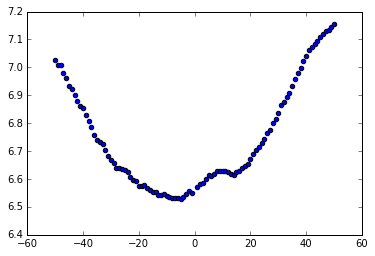

In [5]:
klone = kl.loc[kl.fraction == 1.0]
meanone = klone.mean(axis = 0)
plt.scatter([x for x in range(-50, 51)], meanone[1:])
plt.show()

What about fraction 0.025?

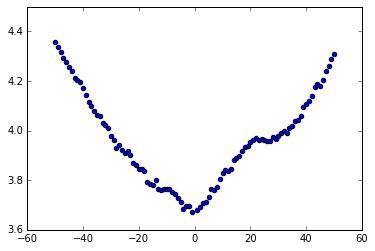

In [6]:
kl25 = kl.loc[kl.fraction == 0.025]
mean25 = kl25.mean(axis = 0)
plt.scatter([x for x in range(-50, 51)], mean25[1:])
plt.show()

If you look at the y axis, this whole curve is lower than the fraction 1 curve, which makes sense.

That "ridge" is an interesting artifact, worth a bit of thought. Might be specific to this time segment; e.g. there's often a discontinuity right at 1900. It's also interesting that the forward or backward tilt of the curve depends on the fraction. Let's try a different period.

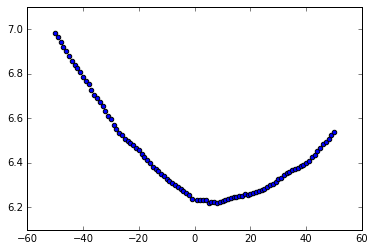

In [8]:
kl20c = pd.read_csv('../results/seg25000klds.tsv', sep = '\t')
klone = kl20c.loc[kl20c.fraction == 1.0]
meanone = klone.mean(axis = 0)
plt.scatter([x for x in range(-50, 51)], meanone[1:])
plt.show()

Okay, wow, that's a rather different curve. Novelty is much higher here; transience much lower. Let's go to the summary files in order to see how those have changed across time. 

### Summary files

Start by loading them all and concatenating them.

In [12]:
paths = glob.glob('../results/*summary.tsv')
paths

['../results/seg10000summary.tsv',
 '../results/seg5000summary.tsv',
 '../results/seg20000summary.tsv',
 '../results/seg30000summary.tsv',
 '../results/seg22500summary.tsv',
 '../results/seg35000summary.tsv',
 '../results/seg25000summary.tsv',
 '../results/seg0summary.tsv',
 '../results/seg17500summary.tsv',
 '../results/seg15000summary.tsv']

In [13]:
dfs = []
for p in paths:
    df = pd.read_csv(p, sep = '\t', index_col = 'docid')
    dfs.append(df)
    print(df.shape)

data = pd.concat(dfs, verify_integrity = True)
print(data.shape)

(5000, 27)
(5000, 27)
(2500, 27)
(5000, 27)
(2500, 27)
(3583, 27)
(5000, 27)
(5000, 27)
(2500, 27)
(2500, 27)
(38583, 27)


In [17]:
## what have we actually got

print(data.columns.tolist())
data.head()

['novelty_1.0_10', 'novelty_1.0_25', 'novelty_1.0_40', 'novelty_0.05_10', 'novelty_0.05_25', 'novelty_0.05_40', 'novelty_0.025_10', 'novelty_0.025_25', 'novelty_0.025_40', 'transience_1.0_10', 'transience_1.0_25', 'transience_1.0_40', 'transience_0.05_10', 'transience_0.05_25', 'transience_0.05_40', 'transience_0.025_10', 'transience_0.025_25', 'transience_0.025_40', 'resonance_1.0_10', 'resonance_1.0_25', 'resonance_1.0_40', 'resonance_0.05_10', 'resonance_0.05_25', 'resonance_0.05_40', 'resonance_0.025_10', 'resonance_0.025_25', 'resonance_0.025_40', 'inferreddate']


,novelty_1.0_10,novelty_1.0_25,novelty_1.0_40,novelty_0.05_10,novelty_0.05_25,novelty_0.05_40,novelty_0.025_10,novelty_0.025_25,novelty_0.025_40,transience_1.0_10,...,resonance_1.0_10,resonance_1.0_25,resonance_1.0_40,resonance_0.05_10,resonance_0.05_25,resonance_0.05_40,resonance_0.025_10,resonance_0.025_25,resonance_0.025_40,inferreddate
docid,,,,,,,,,,,,,,,,,,,,,
hvd.hwtqwj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.802777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800
nyp.33433075724116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.137816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800
nyp.33433075724090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.051975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800
uiuo.ark+=13960=t8pc3pr08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.989976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800
uiuo.ark+=13960=t9572451c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.681724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800


#### meaning of the columns

Novelty and transience can be calculated for all of the fractions we've already explored: 1.0, 0.05, and 0.025.

But in addition, novelty and transience can be averaged across *windows* of different width: ten-year, twenty-five-year, or forty-year windows.

Above you see lots of NaN for novelty, because we're at the start of the timeline, and novelty is undefined with no past to compare things to. If you scroll over, you'll see transience is defined.

#### add date as a variable

In [14]:
data = data.join(meta.inferreddate, how = 'inner')

#### calculate novelty and transience averages by year

We'll use a 10-year window, and slide it forward two years at a time.

We'll consider the 1.0 fraction at a 10-year window.

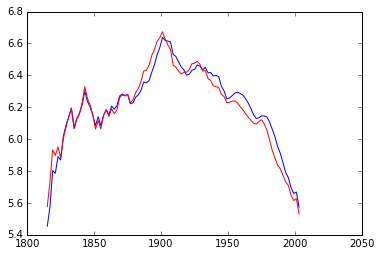

In [21]:
novmeans = []
transmeans = []
years = []

resmeans = []
for floor in range(1810, 2000, 2):
    df = data.loc[(data.inferreddate > floor) & (data.inferreddate < floor + 9), : ]
    nas = np.isnan(df['resonance_1.0_10'])
    novmeans.append(np.mean(df['novelty_1.0_10'][~nas]))
    transmeans.append(np.mean(df['transience_1.0_10'][~nas]))
    years.append(floor + 5)
    
plt.plot(years, novmeans)
plt.plot(years, transmeans, color = 'r')
plt.show()

Wow! To a close approximation, those are the same curves, shifted relative to each other by maybe 5 years.

If the rise and fall were real, this would be enormously significant. But we have pretty good reason to believe that the rise toward the center of the timeline is an artifact of topic modeling, which tends to provide a more granular description of texts at the center of a (long) timeline than it does at the ends--causing differentiation to be higher. (More on our reason for suspecting this, later).

First, let's keep exploring. For instance, what about the 0.025 fraction at a 40-year window?

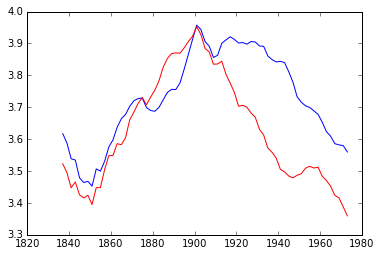

In [22]:
novmeans = []
transmeans = []
years = []

resmeans = []
for floor in range(1810, 2000, 2):
    df = data.loc[(data.inferreddate > floor) & (data.inferreddate < floor + 9), : ]
    nas = np.isnan(df['resonance_0.025_40'])
    novmeans.append(np.mean(df['novelty_0.025_40'][~nas]))
    transmeans.append(np.mean(df['transience_0.025_40'][~nas]))
    years.append(floor + 5)
    
plt.plot(years, novmeans)
plt.plot(years, transmeans, color = 'r')
plt.show()

The general "novelty mountain" effect remains, but the tracking of the curves is thrown off. 40 years out, the 20c does it's own weird thang? Maybe something happening here re: literary differentiation. Remember that this is the 0.025 fraction, so it's measuring the similarity of the most similar works. Transience (red) gets lower in the 20c, so similarity of-the-most-similar is *higher* in the future than in the past.

Note also that this is actually a smaller curve than the 10-year window; if you examine the x axis, you see we've lost about 30 years on each side. So the drop at 1850 which opens this curve is actually also visible in the 10-year window.

### How do we know Novelty Mountain is (at least partly) imaginary?

Well, I've run several other models. For instance, I've run a model only on twentieth (and twenty-first) century data. What novelty pattern do we see there?

In [31]:
paths20 = glob.glob('../20results/*summary.tsv')
paths20

['../20results/seg32500summary.tsv',
 '../20results/seg20000summary.tsv',
 '../20results/seg30000summary.tsv',
 '../20results/seg22500summary.tsv',
 '../20results/seg35000summary.tsv',
 '../20results/seg27500summary.tsv',
 '../20results/seg37500summary.tsv',
 '../20results/seg25000summary.tsv',
 '../20results/seg17500summary.tsv']

In [32]:
dfs = []
for p in paths20:
    df = pd.read_csv(p, sep = '\t', index_col = 'docid')
    dfs.append(df)
    print(df.shape)

data20 = pd.concat(dfs, verify_integrity = True)
data20 = data20.join(meta.inferreddate, how = 'inner')

(2500, 27)
(2500, 27)
(2500, 27)
(2500, 27)
(2500, 27)
(2500, 27)
(1083, 27)
(2500, 27)
(2500, 27)


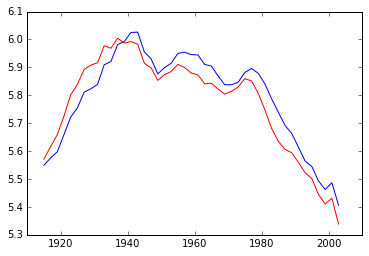

In [33]:
# Run the same curve in the 20c

novmeans = []
transmeans = []
years = []

resmeans = []
for floor in range(1910, 2000, 2):
    df = data20.loc[(data20.inferreddate > floor) & (data20.inferreddate < floor + 9), : ]
    nas = np.isnan(df['resonance_1.0_10'])
    novmeans.append(np.mean(df['novelty_1.0_10'][~nas]))
    transmeans.append(np.mean(df['transience_1.0_10'][~nas]))
    years.append(floor + 5)
    
plt.plot(years, novmeans)
plt.plot(years, transmeans, color = 'r')
plt.show()

The period from 1910-1940, novelty is rising here. But if you look above at our 10-year window plot, novelty is clearly falling in the same period from a global maximum around 1910.

I suspect that kld divergence of one volume to the vols around it is always going to peak in the middle of a topic-modeled timeline, because edge-sampling effects cause models to give a more granular description of the center than of the edges. (I owe my tentative understanding of this partly to conversation with David Mimno and Laure Thompson.)

There are probably real trends as well! The "novelty mountains" we are discovering have some tell-tale asymmetries and bumps. Those tend to match trends in the novelty trajectory I have measured using tdf-idf vectors, to avoid the fisheye-lens distortion of topic modeling.

By collating different models, maybe we can even extract some inferences about the real trend. But that's a conversation for another Jupyter notebook.

### Starting to check our pre-registered hypotheses

So far we've been dwelling on novelty and transience, because they're the ground on which other things are built. But our hypotheses are actually about *resonance* — the difference between them!

You can see that there are some tricky issues in measuring resonance. The "novelty mountain," and more particularly *the lag between its effects on the transience and novelty curves,* will give resonance a diachronic bias.

But I think we can partly solve this by measuring resonance *relative* to books published in a given year (or short segment of the timeline). For instance, to measure resonance in 1925, we might group together all the books published in 1924, 25, and 26, list all the resonances, and normalize the values into z-scores reflecting distance from the local mean resonance.

This will erase long secular trends in resonance — which might have a real existence, quite apart from Novelty Mountain. But here's the other thing: to test our pre-registered hypotheses we probably *want* to neutralize secular trends in resonance. It's very likely that changes in the literary field (e.g. differentiation) have changed the way novelty and transience behave across long timelines. But our pre-registered hypotheses are looking for local differences in the success of specific books. For that purpose, it's probably best to normalize.

In [42]:
zdata = data.copy(deep = True)
columns = data.columns.tolist()
columns.pop(columns.index('inferreddate'))

for col in columns:
    zdata[col] = np.nan
    # set default as empty

for yr in range(1800, 2009):
    print(yr)
    df = data.loc[(data.inferreddate >= yr - 1) & (data.inferreddate <= yr + 1), : ]
    for col in columns:
        nas = np.isnan(df[col])
        seriestonormalize = df.loc[~nas, col]
        indices = seriestonormalize.index.values
        zscores = zscore(seriestonormalize)
        for idx, z in zip(indices, zscores):
            date = df.loc[idx, 'inferreddate']
            if date == yr:
                zdata.loc[idx, col] = z


1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


/Users/tunder/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/tunder/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


#### Correlation of resonance and reprinting

Our metadata contains a column that indicates how many copies of the work I had to roll into one in the process of deduplication. We can take this as a rough measure of the work's afterlife in print.

In [44]:
zdata = zdata.join(meta.allcopiesofwork, how = 'inner')

In [46]:
# let's write that to file

zdata.to_csv('../results/ztransformedsummary.tsv', sep = '\t', index_label = 'docid')

In [45]:
for col in columns:
    if col.startswith('resonance'):
        nas = np.isnan(zdata[col])
        r, p = pearsonr(zdata.loc[~nas, col], zdata.loc[~nas, 'allcopiesofwork'])
        print(col, r, p)
        r, p = pearsonr(zdata.loc[~nas, col], np.log(zdata.loc[~nas, 'allcopiesofwork']))
        print("log-transformed: ", col, r, p)
        print()

resonance_1.0_10 0.0709591107921 2.00791834704e-41
log-transformed:  resonance_1.0_10 0.082909048896 5.93573005657e-56

resonance_1.0_25 0.0628647847045 4.81928116983e-29
log-transformed:  resonance_1.0_25 0.0828699418411 2.84066055938e-49

resonance_1.0_40 0.0501825883609 6.79687570279e-16
log-transformed:  resonance_1.0_40 0.0743445948832 5.06098007024e-33

resonance_0.05_10 0.0874054849793 5.24069801538e-62
log-transformed:  resonance_0.05_10 0.0913892214778 1.21986809278e-67

resonance_0.05_25 0.0806103519402 1.03925298589e-46
log-transformed:  resonance_0.05_25 0.096707917737 1.57944656285e-66

resonance_0.05_40 0.0695190883043 4.47522421866e-29
log-transformed:  resonance_0.05_40 0.0912635932074 5.96294958935e-49

resonance_0.025_10 0.084517403392 4.41502090488e-58
log-transformed:  resonance_0.025_10 0.0892457027324 1.4085485909e-64

resonance_0.025_25 0.0812920296613 1.7820243264e-47
log-transformed:  resonance_0.025_25 0.0975035513332 1.33273680776e-67

resonance_0.025_40 0.07

We have a distinct (if weak) correlation. It's strongest when **allcopiesofwork** is log-transformed, and also distinctly stronger when we focus on smaller fractions of comparison; it peaks at *r* = 0.0975, for a 2.5% fraction and 25-year time radius.

We could correct for multiple comparisons, but that won't change the fact that all of the correlations above are significant.

Reprinting and resonance might seem circular. What if I missed some copies of a book in deduplication? Won't that artificially create a correlation? Maybe. We should check the error rate manually. But note that the error has to take a very particular form to distort our result. If two versions of a title are equally common, and get preserved in deduplication, there will be no distortion, because the earlier one (A) will reduce novelty for (B) as much as (B) reduces transience for A.

The only problematic situation is, if B has many fewer copies than A, and is also later. Only those kinds of errors could create the correlations seen above.

### comparing reviewed and random sets